In [1]:
import sys
sys.version

import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate_data import *
from model_data import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)



WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


exoplanet.__version__ = '0.5.1'


In [2]:
T_subtract = 2454000
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333 - T_subtract
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(70.0)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278 - T_subtract
omega_jup = np.radians(274.3) - 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


m_sun = 333030 #earth masses


orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]


orbit_params = [orbit_params_earth, orbit_params_jup]

times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1800):
	if ii % 50 == 0:
		times_observed_astrometry.append(ii)

n_planets = 2
t_dur_rv = 3650
n_obs_rv = 3000
sigma_rv = 0.3

sigma_theta = 0.05
sigma_rho = 0.001
parallax = 0.1


times, rv_results, theta_results, rho_results = simulate_data(
	n_planets, 
	sigma_rv, 
	sigma_theta,
	sigma_rho,
	parallax,
	orbit_params,
	t_dur_rv = t_dur_rv,
	n_obs_rv = n_obs_rv,
	times_observed_astrometry = times_observed_astrometry
	)


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
	 [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
	 [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
	 [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = times, rv_results, theta_results, rho_results



In [3]:
x_rv = times_observed_rv
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), sigma_rv)

x_astrometry = np.array(times_observed_astrometry)
theta_data = theta_sim_sum
theta_err = np.full(np.shape(theta_data), sigma_theta)
rho_data = rho_sim_sum
rho_err = np.full(np.shape(rho_data), sigma_rho)


# make a fine grid that spans the observation window for plotting purposes
t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

# for predicted orbits
t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)





finding RV model solutions


optimizing logp for variables: [logK, ecs]


message: Optimization terminated successfully.
logp: -601471.7946714238 -> -2739.052286305465
optimizing logp for variables: [logK, ecs, tperi]


message: Desired error not necessarily achieved due to precision loss.
logp: -2739.052286305465 -> -1653.2387849811055
optimizing logp for variables: [logs, ecs, logK, logP, tperi]


message: Desired error not necessarily achieved due to precision loss.
logp: -1653.2387849811055 -> -1651.0183867333344


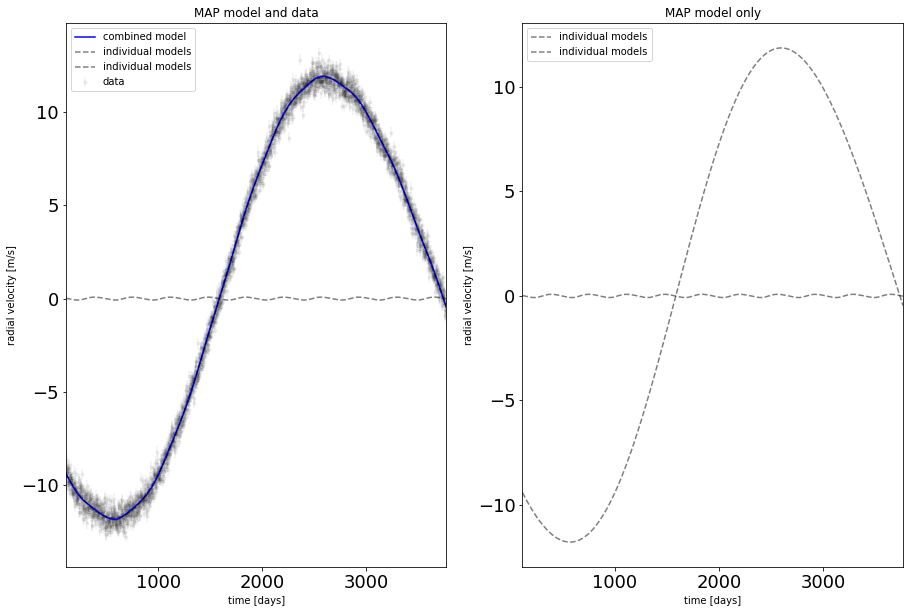

In [4]:

periods_guess = [360, 4330]
Ks_guess = xo.estimate_semi_amplitude(periods_guess, x_rv, y_rv, y_rv_err)


print("finding RV model solutions")
rv_map_soln = model_rv(periods_guess, Ks_guess, x_rv, y_rv, y_rv_err)

fig, ax = plt.subplots(1,2, figsize = [15,10])

ax[0].errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax[0].plot(t_rv, rv_map_soln["rv_model_pred"], "b", label="combined model", zorder=2)
ax[0].plot(t_rv, rv_map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")


ax[0].legend(fontsize=10)
ax[0].set_xlim(t_rv.min(), t_rv.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("MAP model and data")


ax[1].plot(t_rv, rv_map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")
ax[1].legend(fontsize=10)
ax[1].set_xlim(t_rv.min(), t_rv.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
ax[1].set_title("MAP model only")
plt.show()



In [5]:
print("finding joint model solutions")
parallax = 100 # milliarcsec
model, map_soln = model_both(rv_map_soln, x_rv, y_rv, y_rv_err, x_astrometry, 
                             rho_data, rho_err, theta_data, theta_err, parallax)



ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(x_astrometry, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_model_pred"], color="#773f6a")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
	x_astrometry, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_model_pred"], color="#773f6a")
ax[2].errorbar(x_astrometry, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
	x_astrometry, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

plt.show()



finding joint model solutions
[ 363.12820114 4320.67206039]
[ 0.07748496 11.83176695]
[2099.24287139 1634.49414698]
[0.08916698 0.04744317]
[-1.93211132 -1.49582482]


NameError: name 'M_sun' is not defined

In [ ]:


fig, ax = plt.subplots(1, figsize = [9,9])

xs = map_soln["rho_model_pred"] * np.cos(map_soln["theta_model_pred"])  # X is north
ys = map_soln["rho_model_pred"] * np.sin(map_soln["theta_model_pred"])  # Y is east
ax.plot(ys, xs, color="#773f6a", lw=1, label = "RV + astrometry model")


# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k", label = "data")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend()
plt.show()



In [ ]:
plt.figure(figsize=[15,10])
plt.plot(t_rv, map_soln["rv_model_pred"],color="#773f6a", lw=3)
plt.plot(x_rv, y_rv, color='k', alpha=0.3)
plt.xlabel("time [days]")
plt.ylabel("RV [m/s]")
plt.show()

